In [5]:
library(DESeq2)
library(dplyr)
library(purrr)

# Load Data

In [3]:
geneID_name <- readRDS("/home/minghao/workbase/gene_annotation/Ensembl_108_Nile_Tilapia/eggnog_geneID2name.rds")
geneID_name <- geneID_name %>% select(gene = Gene.stable.ID,everything()) 

In [4]:
setwd('/home/songqian/Project/Tilapia_Immune/2.Stat1/4.count')

In [15]:
raw_count <- read.table("RNA-Seq_Practice_countstable")
rownames(raw_count) <- raw_count$V1
raw_count <- raw_count[,2:13]
colnames(raw_count) <- scan("/home/songqian/Project/Tilapia_Immune/2.Stat1/List.txt", what = "character", sep = "\n")
raw_count <- raw_count[-1,]
raw_count[] <- lapply(raw_count, as.numeric)

In [16]:
setwd('/home/songqian/Project/Tilapia_Immune/2.Stat1/4.count')
raw_name <- read.table("group_DEG.txt",h=T)
table(raw_name$group)

rownames(raw_name) <- raw_name$id
raw_name$condition <- raw_name$group


Cold_NC Cold_OE Ctrl_NC Ctrl_OE 
      3       3       3       3 

In [17]:
condition_level <- c("Cold_NC","Cold_OE","Ctrl_NC","Ctrl_OE")

In [18]:
raw_name$subject <- gsub("[a-zA-Z]*_[a-zA-Z]*","",raw_name$id) 
raw_name$condition <- factor(raw_name$condition)
raw_name$subject <- factor(raw_name$subject)

In [21]:
dds <- DESeqDataSetFromMatrix(countData = raw_count,
                              colData = raw_name,
                              design = ~ subject + condition)

converting counts to integer mode



In [22]:
keep <- rowSums(counts(dds) >= 1) >= 3
dds2 <- dds[keep,]

# Find DEGs

In [23]:
run_DESeq <- function(object , condition , DETest_level){
    dds.sample <- object[,grep(x = colnames(object),pattern = condition,ignore.case = T,value = T)]
    print(paste0("running:",condition))
    colData(dds.sample) <- droplevels(colData(dds.sample))
    
    dds.sample$condition <- factor(dds.sample$condition, levels = DETest_level)
    design(dds.sample) <- formula(~ subject + condition)
    print(design(dds.sample))
    dds.sample <- DESeq(dds.sample)
    res <- results(dds.sample, contrast = c("condition",DETest_level[2],DETest_level[1])) %>% 
        as.data.frame %>% arrange(padj) %>% tibble::rownames_to_column(var = "gene") %>% 
        mutate(group = paste(DETest_level[2],DETest_level[1],sep = "_vs_"))
    return(list(dds = dds.sample,result = res))
}

In [24]:
dds_nc <- run_DESeq(object = dds,condition = "NC",DETest_level = c("Ctrl_NC","Cold_NC"))
dds_oe <- run_DESeq(object = dds,condition = "OE",DETest_level = c("Ctrl_OE","Cold_OE"))
dds_ctrl <- run_DESeq(object = dds,condition = "Ctrl",DETest_level = c("Ctrl_NC","Ctrl_OE"))
dds_cold <- run_DESeq(object = dds,condition = "Cold",DETest_level = c("Cold_NC","Cold_OE"))

[1] "running:NC"
~subject + condition
<environment: 0x5620bed07a80>


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "running:OE"
~subject + condition
<environment: 0x5620ce77dc18>


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "running:Ctrl"
~subject + condition
<environment: 0x5620cf061bb0>


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "running:Cold"
~subject + condition
<environment: 0x5620c9f5b438>


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [25]:
DEG.RNA <- map_dfr(list(dds_nc,dds_oe,dds_ctrl,dds_cold),`[[`,2)

In [27]:
#读取此前分析的结果(stat1下游靶基因)
stat1_target_gene <- openxlsx::read.xlsx("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output/20240614_STAT1_target_gene.xlsx")

In [32]:
load("/home/minghao/database/KEGG_GO_database/02_niletilapia/01_enrichment_gos_keggs/go_info.RData")
load("/home/minghao/database/KEGG_GO_database/02_niletilapia/01_enrichment_gos_keggs/kegg_info.RData")

In [200]:
#apo pathway gene & stat1 target gene & DEGs
DEG.RNA2_intersect2 <- DEG.RNA2_intersect[DEG.RNA2_intersect$gene %in% kegg_apo_genes,] %>% left_join(geneID_name,by = "gene")

Warning message in left_join(., geneID_name, by = "gene"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 4 of `x` matches multiple rows in `y`.
ℹ Row 16966 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


## Stat1 target gene enrichment

In [34]:
stat1_target_gene <- openxlsx::read.xlsx("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output/20240614_STAT1_target_gene.xlsx")

In [39]:
stat1_target_gene2 <- stat1_target_gene %>% select(term = cluster,gene) %>% unique

In [40]:
term2gene_v2 <- data.frame(term = "All_stat1_target_gene",gene = stat1_target_gene$gene) %>% rbind(stat1_target_gene2)

In [41]:
Run_GSEA <- function(Fold_change,gene_name,gsea_set,methods = "fgsea",eps_value = 1e-10){
    genelist <- Fold_change
    names(genelist) <- gene_name
    gsea <- clusterProfiler::GSEA(genelist,
             pvalueCutoff = 1,
             TERM2GENE = gsea_set,
             minGSSize = 3,
             maxGSSize = 800,
             eps = eps_value,
             by = methods,
             nPermSimple = 10000) #GSEA分析
    return(gsea)
}

In [42]:
options(warn = 1)

In [47]:
DEG.RNA %>% na.omit %>% mutate(logP = -log10(pvalue + 1e-50)) %>% 
    group_by(group) %>% arrange(desc(logP),.by_group = T) %>% select(gene,logP,group) %>% 
    split(.$group) %>% map(~ {
        Run_GSEA(Fold_change = .x$logP, gene_name = .x$gene, gsea_set = term2gene_v2, methods = "fgsea", eps_value = 0)
    }) -> gsea_logP_res

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (22.62% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std

In [44]:
names(gsea_logP_res)

[1] "Cold_NC_vs_Ctrl_NC" "Cold_OE_vs_Cold_NC" "Cold_OE_vs_Ctrl_OE"
[4] "Ctrl_OE_vs_Ctrl_NC"

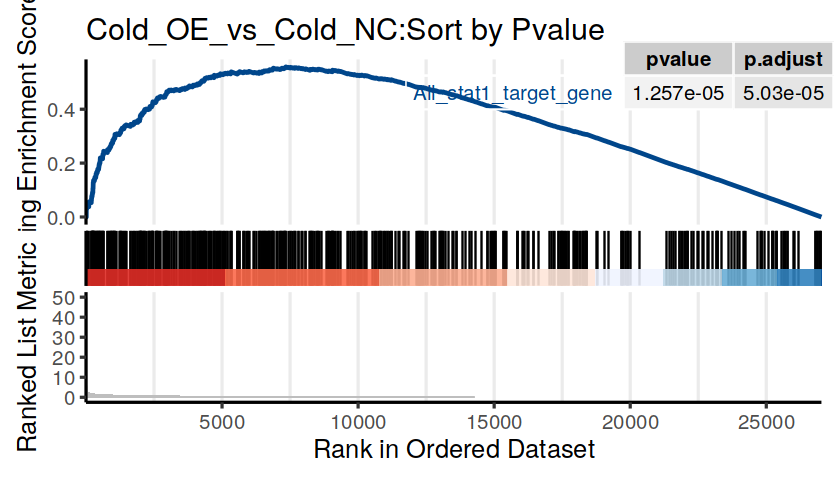

In [951]:
options(repr.plot.width = 7,repr.plot.height = 4)
gsea_plot <- enrichplot::gseaplot2(gsea_logP_res[["Cold_OE_vs_Cold_NC"]],title = "Cold_OE_vs_Cold_NC:Sort by Pvalue",
                      base_size = 15,
                      rel_heights = c(1.5,0.5,1.0),
                      color = ggsci::pal_lancet()(1),subplots = 1:3,
                      geneSetID = c("All_stat1_target_gene"), 
                      ES_geom = "line",
                      pvalue_table = T)
gsea_plot

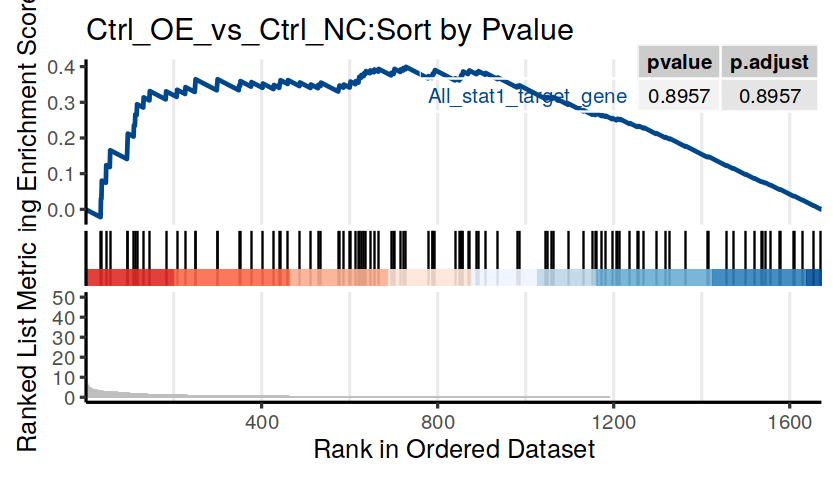

In [50]:
options(repr.plot.width = 7,repr.plot.height = 4)
enrichplot::gseaplot2(gsea_logP_res[["Ctrl_OE_vs_Ctrl_NC"]],title = "Ctrl_OE_vs_Ctrl_NC:Sort by Pvalue",
                      base_size = 15,
                      rel_heights = c(1.5,0.5,1.0),
                      color = ggsci::pal_lancet()(1),subplots = 1:3,
                      geneSetID = c("All_stat1_target_gene"), 
                      ES_geom = "line",
                      pvalue_table = T) 

In [693]:
DEG.RNA %>% na.omit %>% 
    group_by(group) %>% arrange(desc(log2FoldChange),.by_group = T) %>% select(gene,log2FoldChange,group) %>% 
    split(.$group) %>% map(~ {
        Run_GSEA(Fold_change = .x$log2FoldChange, gene_name = .x$gene, gsea_set = term2gene_v2, methods = "fgsea", eps_value = 0)
    }) -> gsea_FC_res

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 100000)”
leading edge analysis...

done...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (22.62% of the list).
The order of those tied genes will be arbitrary, which may produce unexpe

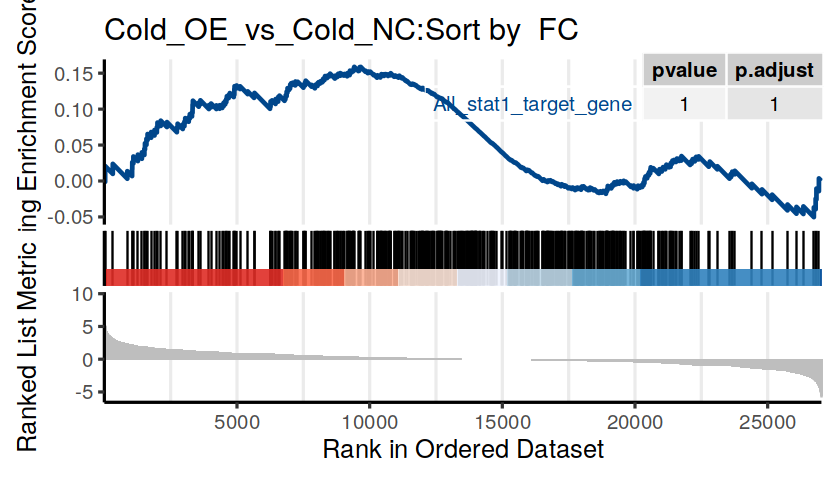

In [694]:
options(repr.plot.width = 7,repr.plot.height = 4)
enrichplot::gseaplot2(gsea_FC_res[["Cold_OE_vs_Cold_NC"]],title = "Cold_OE_vs_Cold_NC:Sort by  FC",
                      base_size = 15,
                      rel_heights = c(1.5,0.5,1.0),
                      color = ggsci::pal_lancet()(1),subplots = 1:3,
                      geneSetID = c("All_stat1_target_gene"), 
                      ES_geom = "line",
                      pvalue_table = T) 

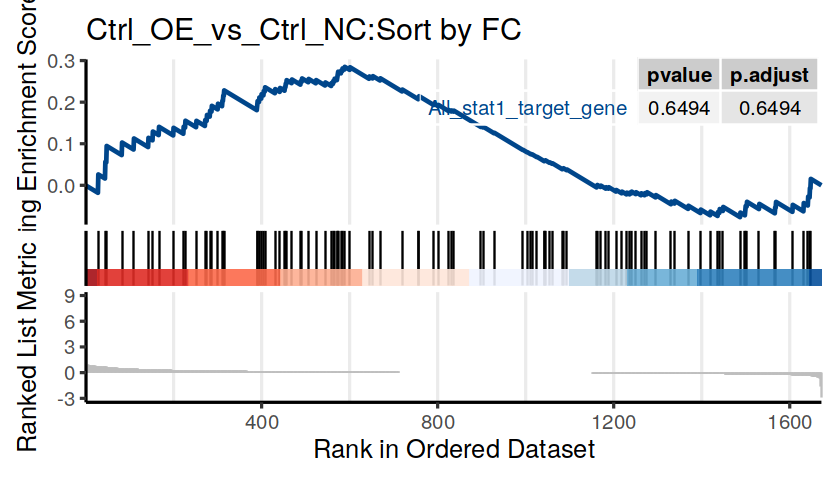

In [695]:
options(repr.plot.width = 7,repr.plot.height = 4)
enrichplot::gseaplot2(gsea_FC_res[["Ctrl_OE_vs_Ctrl_NC"]],title = "Ctrl_OE_vs_Ctrl_NC:Sort by FC",
                      base_size = 15,
                      rel_heights = c(1.5,0.5,1.0),
                      color = ggsci::pal_lancet()(1),subplots = 1:3,
                      geneSetID = c("All_stat1_target_gene"), 
                      ES_geom = "line",
                      pvalue_table = T) 

In [700]:
Cold_OE_vs_Cold_NC_order_gene <- DEG.RNA %>% na.omit %>% mutate(logP = -log10(pvalue + 1e-50)) %>% 
    group_by(group) %>% arrange(desc(logP),.by_group = T) %>% select(gene,logP,group) %>% 
    split(.$group) %>% .$Cold_OE_vs_Cold_NC

In [751]:
gsea_logP_res_cold <- gsea_logP_res[["Cold_OE_vs_Cold_NC"]]@result

In [759]:
stringr::str_split(string = gsea_logP_res_cold$core_enrichment[1],pattern = "/",simplify = T) %>% 
    t() %>% as.data.frame -> all_bar_gene

In [786]:
bar_gene <- c("ENSONIG00000004934","ENSONIG00000021256","ENSONIG00000003745",
              "ENSONIG00000004349","ENSONIG00000007023","ENSONIG00000001178","ENSONIG00000019499")
bar_gene_name <- c("tlr1","jun","map3k8",
                   "nfkb1","nfkb2","nfkbiaa","nfkbiab")
names(bar_gene_name) <- bar_gene

In [712]:
mat=read.table("/home/songqian/Project/Tilapia_Immune/2.Stat1/4.count/RNA-Seq_tpm_countstable.xls",header=TRUE,row.names=1,sep="\t",check.names = F)
TPM <- mat %>% dplyr::select(grep(colnames(mat),pattern = "^Ctrl_",value = T),everything())   #将Ctrl组前置
TPM <- mat[rowSums(TPM)> 0,]

In [846]:
TPM[all_bar_gene$V1,] %>% tibble::rownames_to_column("gene") %>% 
    select(gene,matches(match = "Cold")) %>% apply(. , 1 ,function(x){
        cold_nc <- as.numeric(x[2:4])  
        cold_oe <- as.numeric(x[5:7])
        t.test(cold_nc, cold_oe, paired = T)$p.value 
    }) -> results 

In [837]:
results_df <- data.frame(gene = rownames(TPM[all_bar_gene$V1,]), p_value = results)  

In [868]:
apo_go <- go_des[grep(go_des$description,pattern = "apoptotic|apotosis"),]$GO %>% unique
apo_go_gene <- gos$gene[gos$GO %in% apo_go] %>% unique

In [880]:
results_df %>% filter(p_value < 0.05) %>% 
    left_join(geneID_name,by = "gene") %>% 
    filter(gene %in% unique(union(kegg_apo_genes,apo_go_gene)) )

gene,p_value,Gene.name,eggnog_Preferred_name,eggnog_Description
<chr>,<dbl>,<chr>,<chr>,<chr>
ENSONIG00000008483,0.04758552,NR3C1,NR3C1,"Nuclear receptor subfamily 3, group C, member 1"


Using gene as id variables



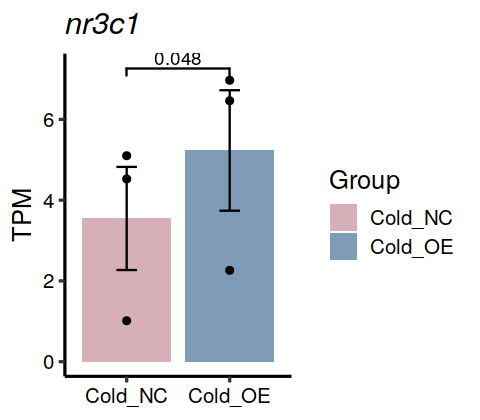

In [892]:
options(repr.plot.width = 4,repr.plot.height = 3.5)
mat["ENSONIG00000008483",] %>% tibble::rownames_to_column("gene") %>% select(gene,matches(match = "Cold")) %>% reshape2::melt() %>% 
    mutate(group = gsub("\\d","",variable),rep = gsub("\\D","",variable)) %>% 
    ggplot(aes(x = group,y = value,fill = group)) + 
        geom_bar(stat = "summary",fun=mean,width = 0.85) + 
        geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, color = "black",size = 0.5)+
        geom_point(show.legend = F) + 
        scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) + 
        #facet_wrap(~gene,ncol = 2,scales = "free",labeller = labeller(gene = bar_gene_name)) + 
        #scale_y_continuous(expand = c(0,0)) +
        labs(fill = "Group" , y = "TPM",x = NULL)  +
        theme_classic(base_size = 15) + 
        ggtitle("nr3c1") + 
        theme(plot.title = element_text(face = "italic"),axis.text = element_text(color = "black"),
              strip.text.x.top = element_text(face = "italic"),
              strip.background = element_blank()) +
        ggsignif::geom_signif(comparisons = list(c("Cold_NC", "Cold_OE")),test.args = list(paired = TRUE),
                              test = "t.test",,map_signif_level = F) 

In [941]:
geneID_name[grep(geneID_name$gene,pattern = "ENSONIG00000043218"),]

,gene,Gene.name,eggnog_Preferred_name,eggnog_Description
,<chr>,<chr>,<chr>,<chr>
29007,ENSONIG00000043218,,bcl2l14,Apoptosis facilitator


In [53]:
gsea_gene <- c("ENSONIG00000004349","ENSONIG00000007023","ENSONIG00000001178","ENSONIG00000019499",
              "ENSONIG00000015793","ENSONIG00000020647","ENSONIG00000011785","ENSONIG00000003728",
              "ENSONIG00000008283","ENSONIG00000028050","ENSONIG00000043218","ENSONIG00000008483")
gsea_gene_name <- c("nfkb1","nfkb2","nfkbiaa","nfkbiab",
                   "syvn1","socs1","traf3","cd274",
                   "ddx5","bcl2l11","bcl2l14","nr3c1")

names(gsea_gene) <- gsea_gene_name

gsea_gene <- data.frame(gene = gsea_gene , name = gsea_gene_name)

In [73]:
gsea_plot2 <- gsea_plot
gsea_plot2[[1]] <- gsea_plot2[[1]] + geom_text_repel(data = gsea_plot2[[1]]$data %>% inner_join(gsea_gene,by = "gene"),
                                   aes(x = x,y = runningScore,label = name),size = 3.5)

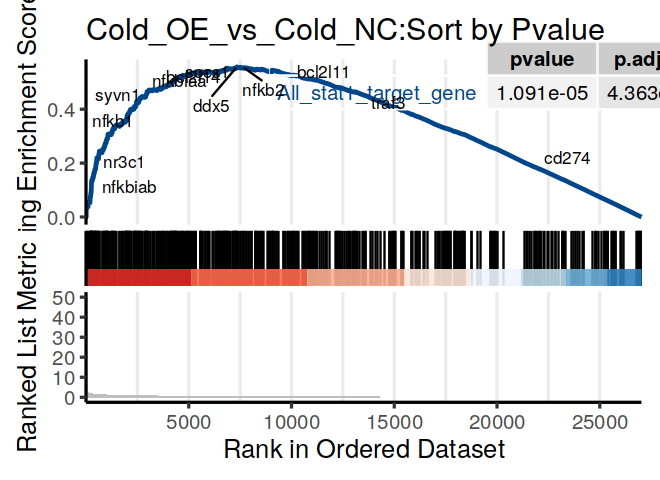

In [74]:
options(repr.plot.width = 5.5,repr.plot.height = 4)
gsea_plot2

In [1002]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/stat1OE_plot/stat1_targetgene_gsea.pdf",width = 5.5,height = 4)
gsea_plot2
dev.off()

png 
  2

In [59]:
ctrl_gsea_plot <- enrichplot::gseaplot2(gsea_logP_res[["Ctrl_OE_vs_Ctrl_NC"]],title = "Ctrl_OE_vs_Ctrl_NC:Sort by Pvalue",
                      base_size = 15,
                      rel_heights = c(1.5,0.5,1.0),
                      color = ggsci::pal_lancet()(1),subplots = 1:3,
                      geneSetID = c("All_stat1_target_gene"), 
                      ES_geom = "line",
                      pvalue_table = T) 

In [60]:
ctrl_gsea_plot2 <- ctrl_gsea_plot
ctrl_gsea_plot2[[1]] <- ctrl_gsea_plot2[[1]] + geom_text_repel(data = ctrl_gsea_plot2[[1]]$data %>% inner_join(gsea_gene,by = "gene"),
                                   aes(x = x,y = runningScore,label = name),size = 3.5)

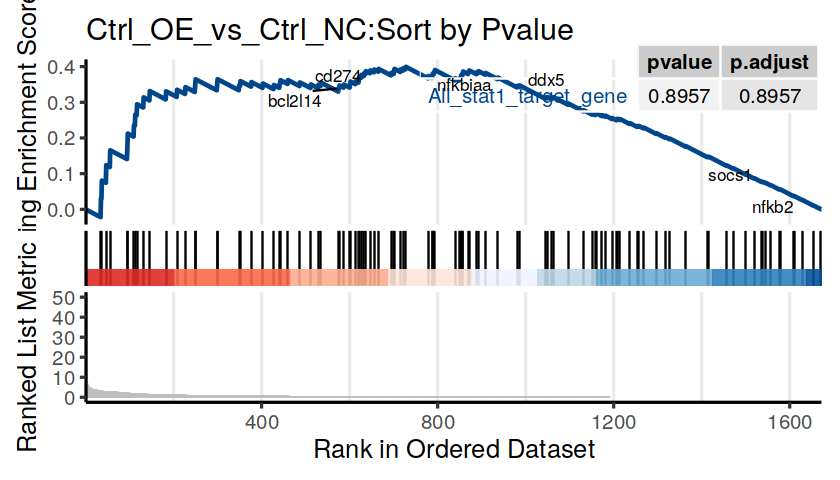

In [61]:
ctrl_gsea_plot2

In [69]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/stat1OE_plot/ctrl_stat1_targetgene_gsea.pdf",width = 5.5,height = 4)
options(repr.plot.width = 7,repr.plot.height = 4)
ctrl_gsea_plot2
dev.off()

png 
  2

Using gene as id variables



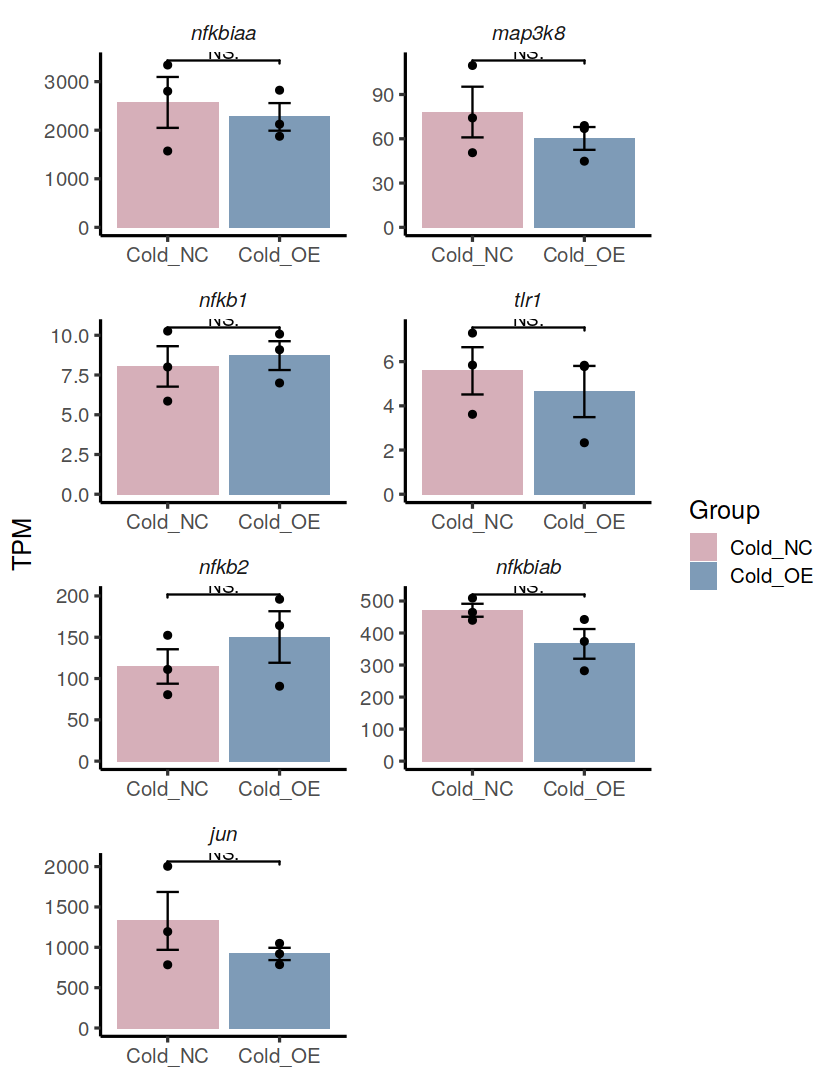

In [900]:
options(repr.plot.width = 7,repr.plot.height = 9)
TPM[bar_gene,] %>% tibble::rownames_to_column("gene") %>% select(gene,matches(match = "Cold")) %>% reshape2::melt() %>% 
    mutate(group = gsub("\\d","",variable),rep = gsub("\\D","",variable)) %>% 
    ggplot(aes(x = group,y = value,fill = group)) + 
        geom_bar(stat = "summary",fun=mean) + 
        geom_errorbar(stat = "summary", fun.data = mean_se, width = 0.2, color = "black",size = 0.5)+
        geom_point(show.legend = F) + 
        scale_fill_manual(values = c("#D6AFB9","#7E9BB7")) + 
        facet_wrap(~gene,ncol = 2,scales = "free",labeller = labeller(gene = bar_gene_name)) + 
        #scale_y_continuous(expand = c(0,0)) +
        labs(fill = "Group" , y = "TPM",x = NULL)  +
        theme_classic(base_size = 15) + 
        theme(strip.text.x.top = element_text(face = "italic"),strip.background = element_blank()) +
        ggsignif::geom_signif(comparisons = list(c("Cold_NC", "Cold_OE")), test = "t.test",test.args = list(paired = T),
                              ,map_signif_level = TRUE)